In [1]:
!pip3 install polars


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import polars as pl
import os

In [3]:
CLEAN_DATA = False

In [4]:
# JOIN DATASETS

if CLEAN_DATA: 
    stations = pl.read_csv("dataset/stations.csv")  
    station_day = pl.read_csv("dataset/station_day.csv")
    df = stations.join(station_day, on="StationId")
    df.write_csv("dataset/full_data.csv", separator=",")

    df = pl.read_csv("dataset/full_data.csv")
    df

In [5]:
# FILTER TO CITIES WITH MORE THAN 3 CITIES

if CLEAN_DATA: 

  df.select(["StationId", "City"]) \
      .group_by("City", "StationId").count()

  cities_wo_3sts = df.select(["StationId", "City"]).unique().group_by("City") \
    .count().filter(pl.col("count") > 3).sort("count")["City"].to_list()

  print(cities_wo_3sts)

  df = df.filter(pl.col("City").is_in(cities_wo_3sts)).select(["StationId", "City", "Date", "Status", "PM2.5", "PM10", "NOx", "CO", "SO2", "O3"])

  df.select(pl.all().is_null().sum()).drop(["StationId", "City", "Date", "Status"])

In [6]:
# FILTERED TO STATIONS WITH MORE THAN 500 ROWS + DROP ROWS WITH NULL VALUES + PICK CITY (DELHI)

if CLEAN_DATA: 
    temp_df = df.group_by("City", "StationId").count().sort("count").filter(pl.col("count") > 500)

    df = df.join(temp_df, on=["StationId", "City"])
    df

    df.drop_nulls().group_by("StationId", "City").count().sort("count")

    df = df.drop_nulls().filter(pl.col("City").is_in(["Delhi"]))
    print(df.shape)
    print("Unique stations in Delhi: ", len(df.select("StationId").unique()["StationId"].to_list()))

    df = df.drop("count")

    df.write_csv("dataset/cleaned_data.csv", separator=",")

In [7]:
df = pl.read_csv("dataset/cleaned_data.csv")
df

StationId,City,Date,Status,PM2.5,PM10,NOx,CO,SO2,O3
str,str,str,str,f64,f64,f64,f64,f64,f64
"""DL001""","""Delhi""","""2018-11-11""","""Active""",232.36,415.28,43.87,1.49,23.48,46.28
"""DL001""","""Delhi""","""2018-11-12""","""Active""",238.43,348.91,44.63,1.53,14.38,45.31
"""DL001""","""Delhi""","""2018-11-13""","""Active""",284.83,427.4,76.15,1.43,21.33,30.4
"""DL001""","""Delhi""","""2018-11-14""","""Active""",150.41,214.16,56.3,0.99,12.74,41.87
"""DL001""","""Delhi""","""2018-11-15""","""Active""",106.11,154.36,47.21,0.7,12.46,27.93
…,…,…,…,…,…,…,…,…,…
"""DL038""","""Delhi""","""2020-06-27""","""Active""",41.85,156.2,30.21,1.55,24.48,12.19
"""DL038""","""Delhi""","""2020-06-28""","""Active""",48.42,284.41,40.5,1.44,24.31,12.58
"""DL038""","""Delhi""","""2020-06-29""","""Active""",42.64,172.11,31.08,1.29,19.87,17.99


# 4. Time Series Plots

In [8]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [9]:
# Convert the 'Date' column to date format instead of 'str' for proper time series plotting
df = df.with_columns(
    pl.col('Date').str.to_date()
)

selected_stations = ['DL031', 'DL002', 'DL028', 'DL019']

df = df.filter(
    pl.col('StationId').is_in(selected_stations)
)

df = df.filter(pl.col("Date") >= pl.lit("2017-10-01").cast(pl.Date))

In [10]:
# List of air quality parameters to plot
air_metrics = ['PM2.5', 'PM10', 'NOx', 'CO', 'SO2', 'O3']

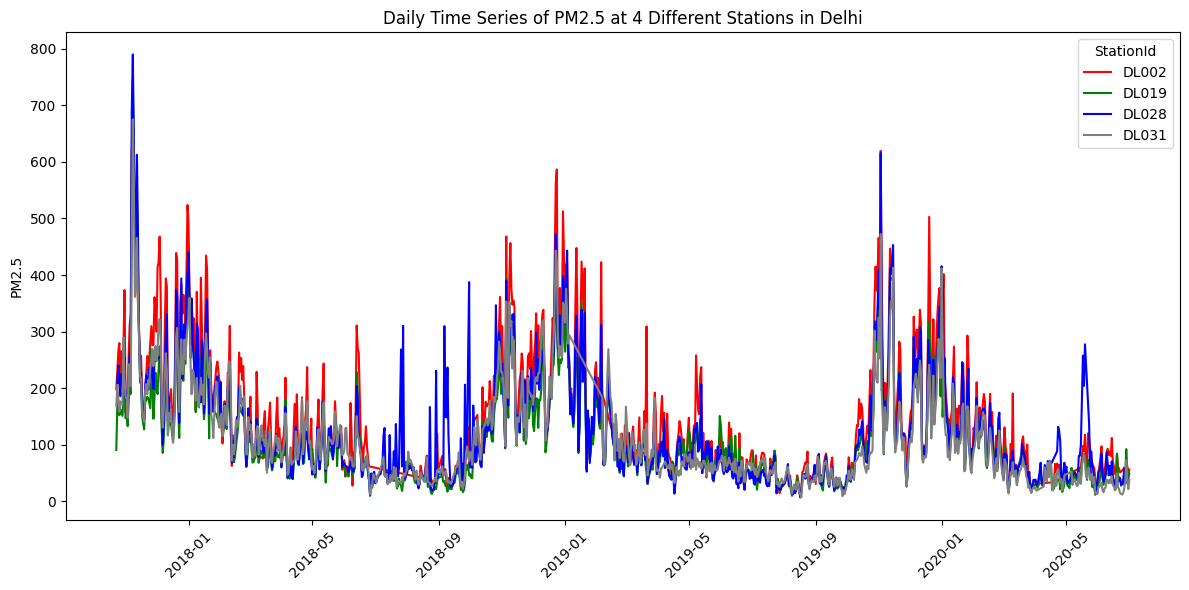

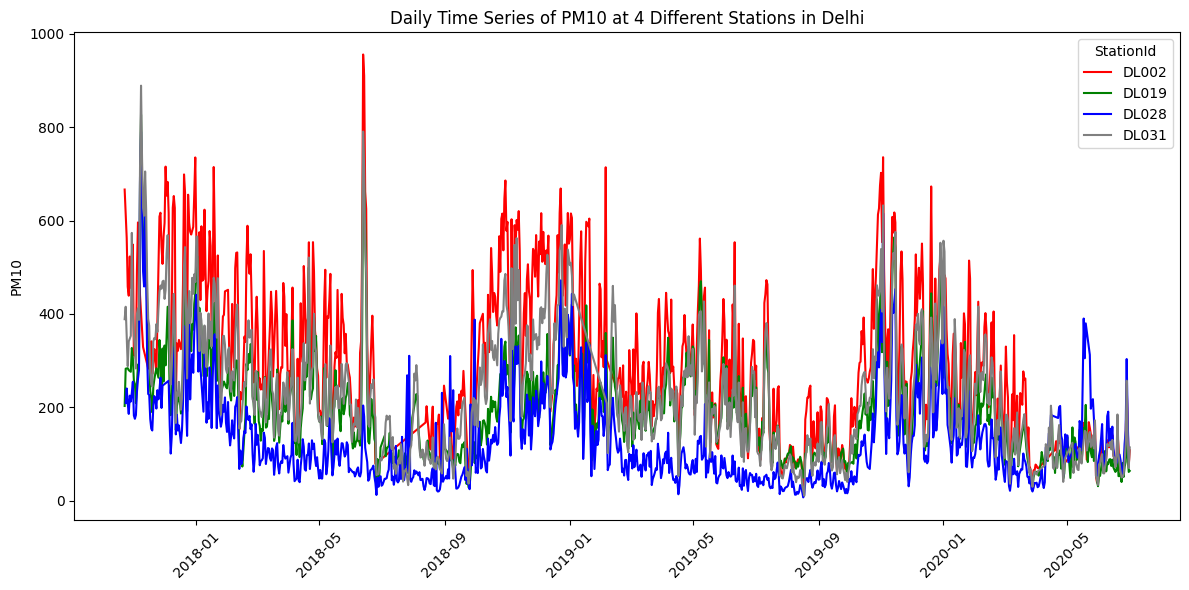

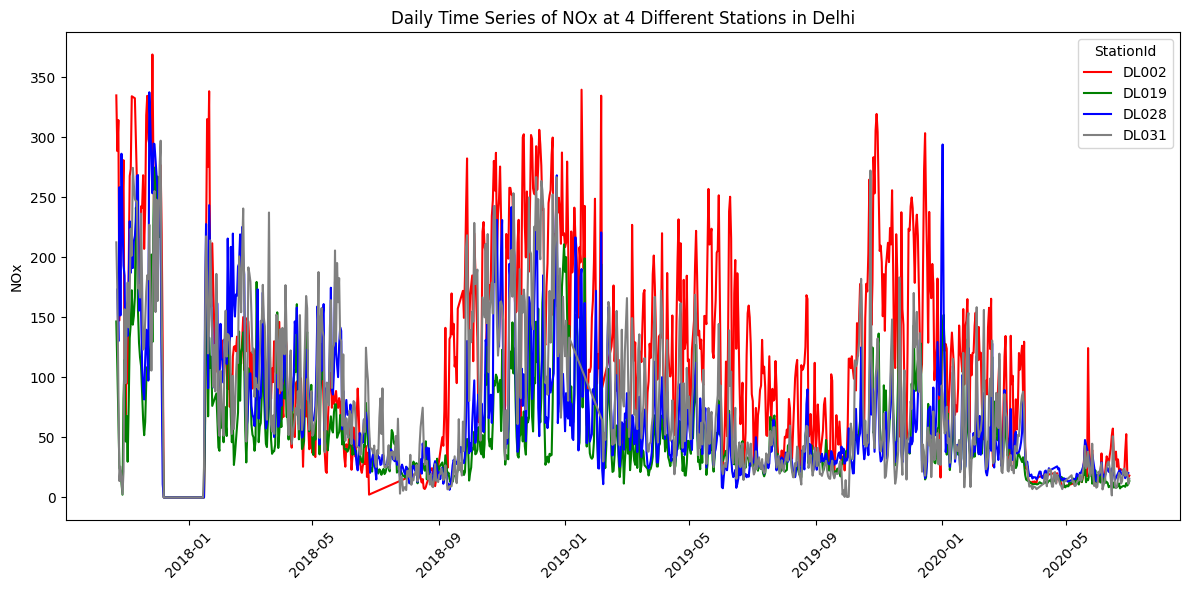

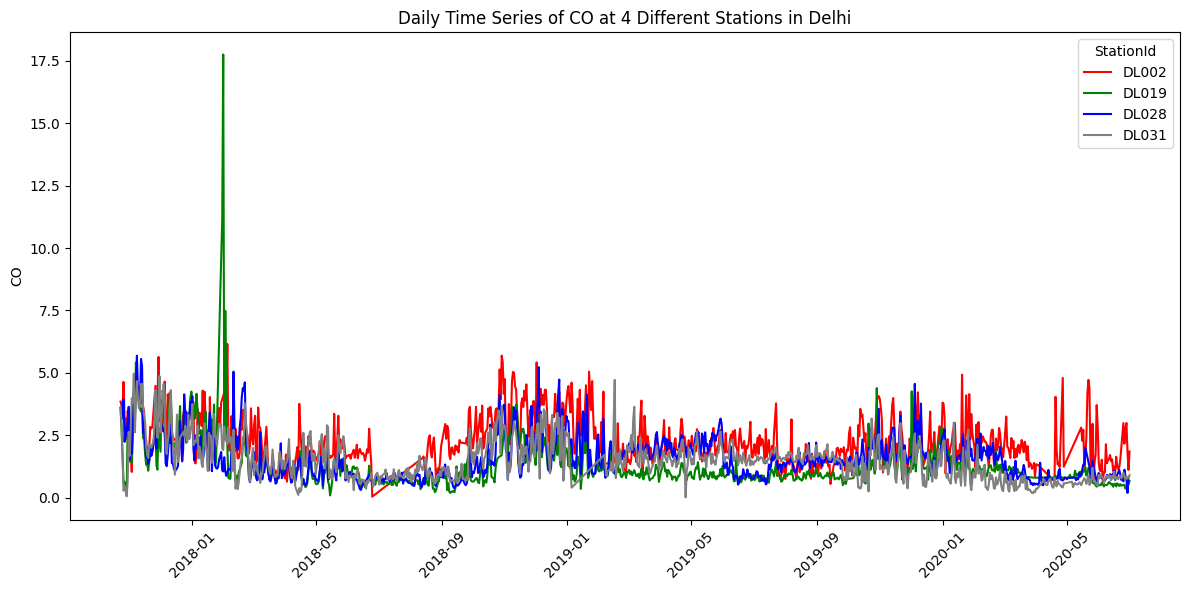

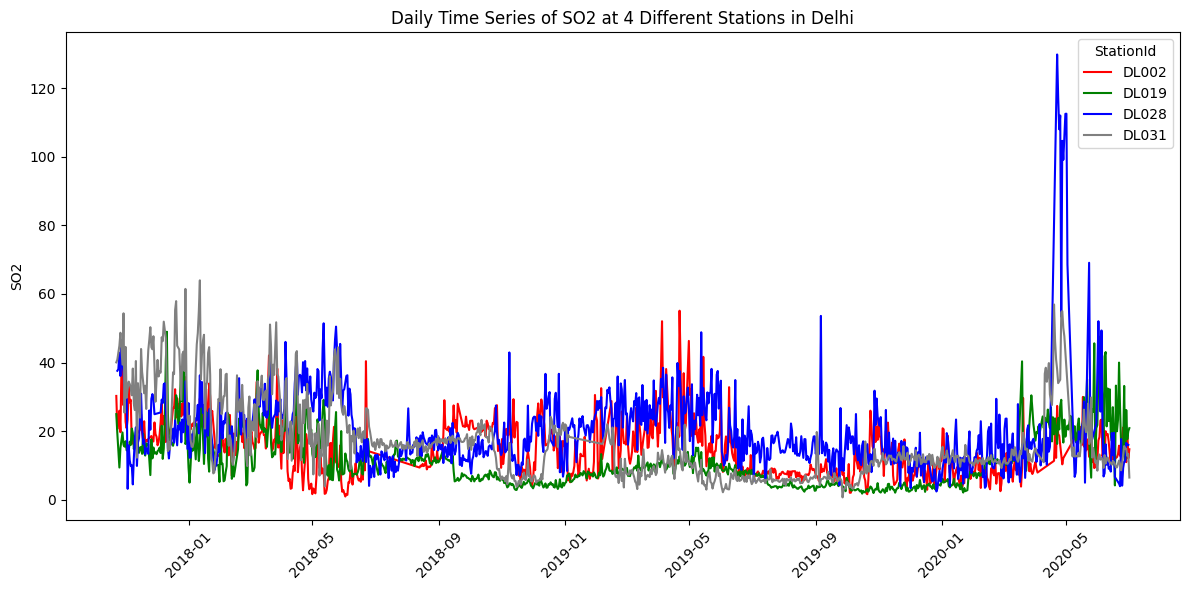

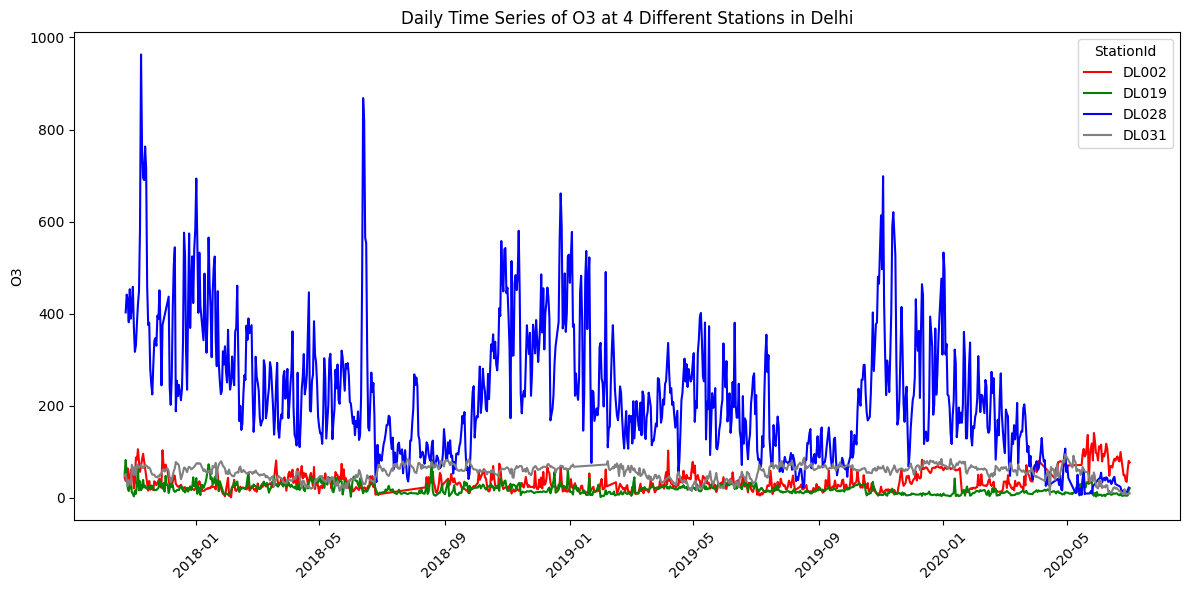

In [11]:
# Loop through each parameter and plot
for air_metric in air_metrics:
    # Initialize the figure for each parameter
    plt.figure(figsize=(12, 6))
    
    # Create the lineplot
    sns.lineplot(
        data=df, 
        x='Date', 
        y=air_metric, 
        hue='StationId',
        palette = ['red', 'green', 'blue', 'grey']
    )
    
    # Set plot title and labels
    plt.title(f'Daily Time Series of {air_metric} at 4 Different Stations in Delhi')
    plt.ylabel(air_metric)
    plt.xlabel("")
    
    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent clipping of titles/labels
    plt.tight_layout()
    
    # Show the plot
    plt.show()


In [12]:
df_monthly = df.with_columns(pl.col("Date").dt.month().alias("month")) \
    .with_columns(pl.col("Date").dt.year().alias("year")) \
    .with_columns(pl.concat_str([pl.col("year"), pl.col("month")], separator="-").alias("Year-Month")) \
    .group_by("StationId", "Year-Month", "month", "year").agg([pl.col(metric).mean().alias(metric) for metric in air_metrics]) \
    .sort("year", "month")

# Save or view the result
df_monthly.write_csv("monthly_aggregated_data.csv")

display(df_monthly)

StationId,Year-Month,month,year,PM2.5,PM10,NOx,CO,SO2,O3
str,str,i8,i32,f64,f64,f64,f64,f64,f64
"""DL028""","""2017-10""",10,2017,220.73875,220.73875,200.90125,3.0725,38.84,421.94875
"""DL031""","""2017-10""",10,2017,197.525714,394.808571,86.475714,1.525714,41.95,47.322857
"""DL002""","""2017-10""",10,2017,261.292222,532.438889,235.533333,3.446667,28.222222,48.327778
"""DL019""","""2017-10""",10,2017,161.494286,279.657143,71.55,1.894286,17.12,32.542857
"""DL002""","""2017-11""",11,2017,272.483636,406.91,242.746818,3.084545,20.969091,48.071818
…,…,…,…,…,…,…,…,…,…
"""DL031""","""2020-6""",6,2020,28.441667,98.014667,19.152333,0.82,11.628,18.460667
"""DL028""","""2020-6""",6,2020,47.908889,121.897037,20.200741,0.819259,16.091481,31.28963
"""DL002""","""2020-7""",7,2020,56.25,108.0,18.2,1.85,14.72,77.25


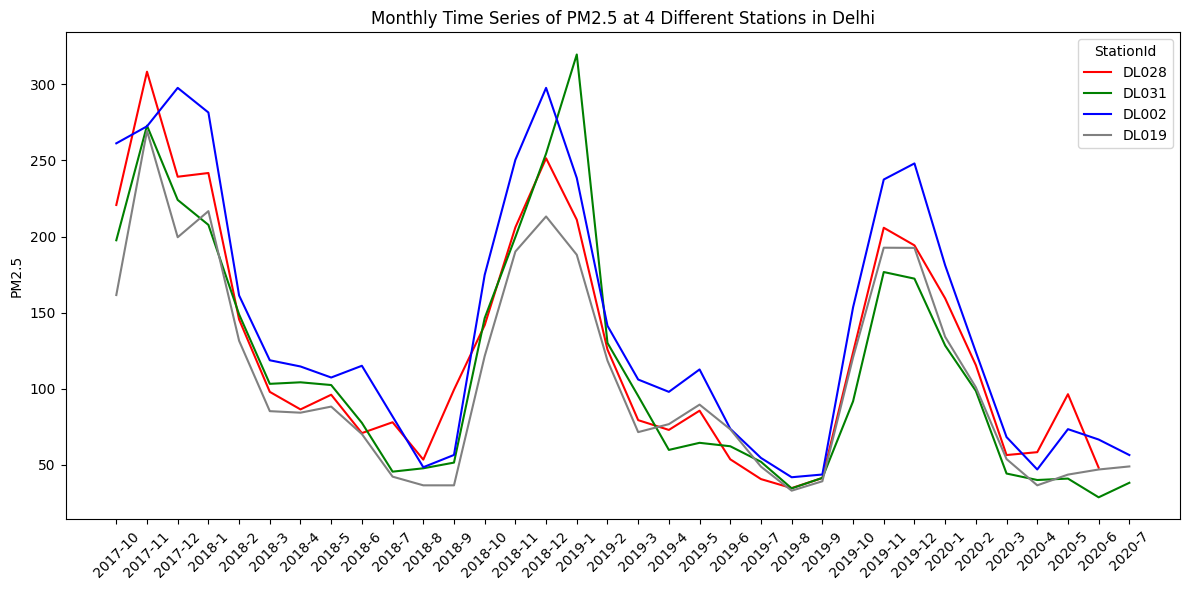

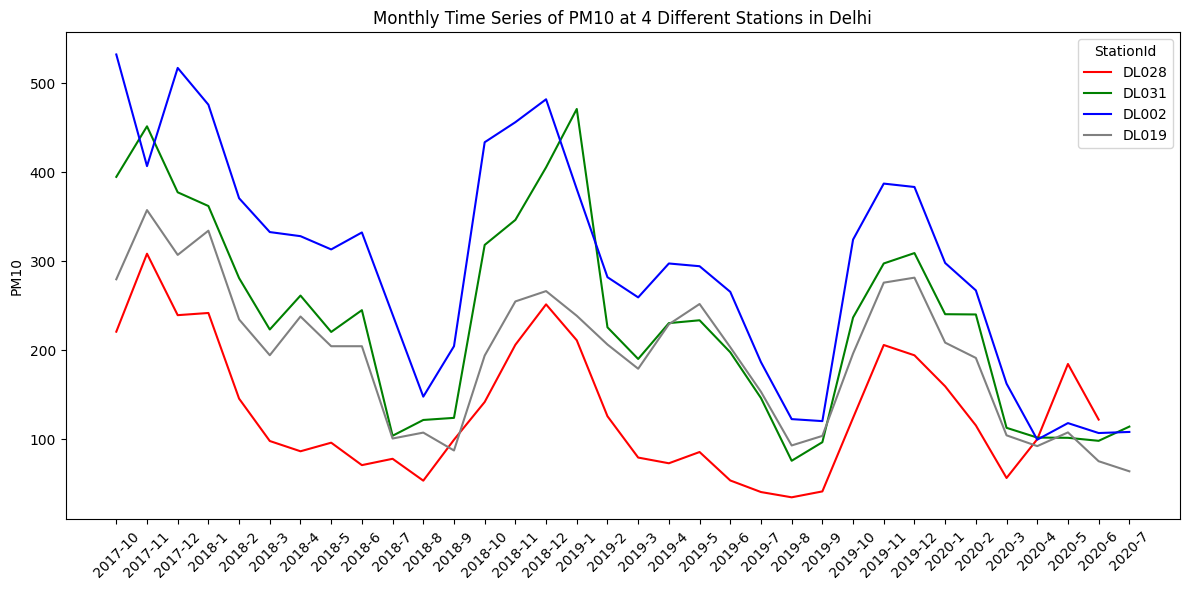

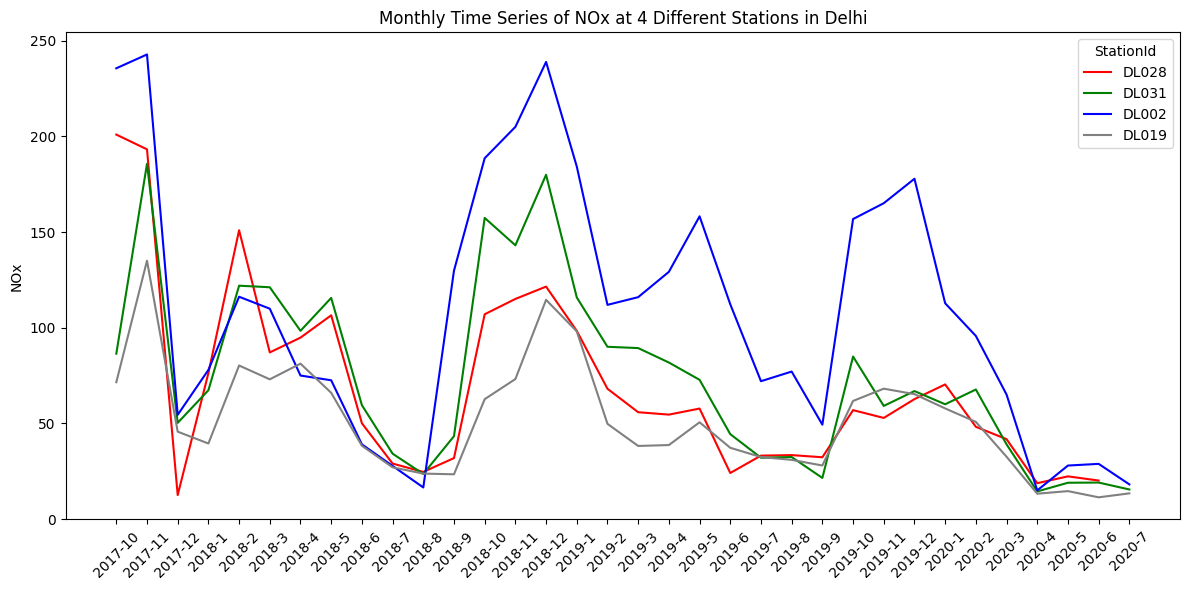

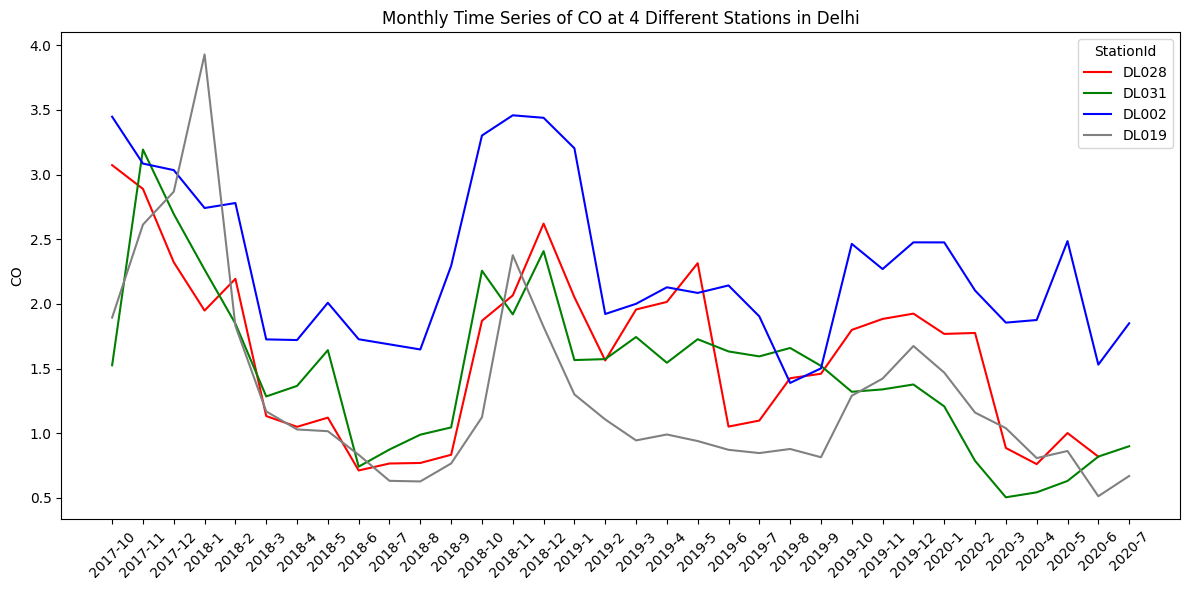

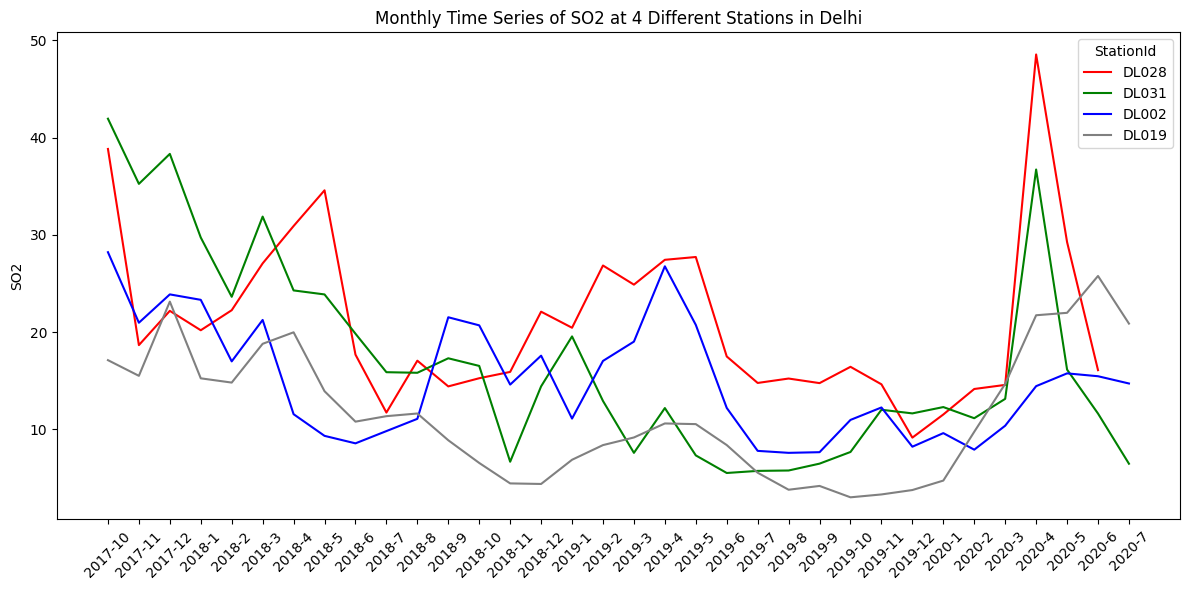

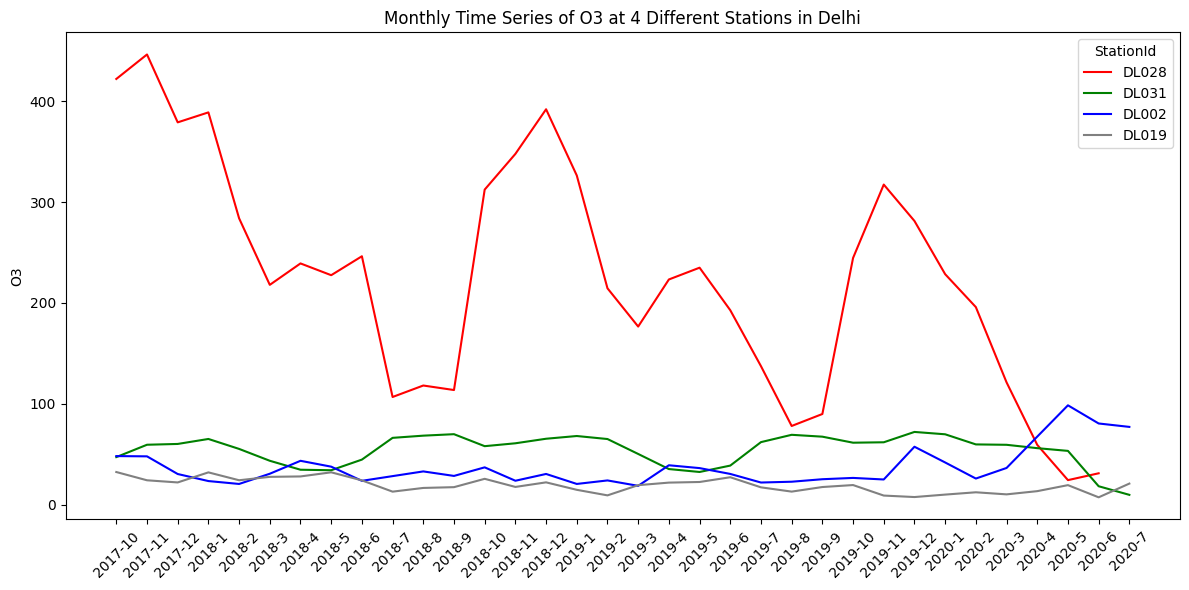

In [17]:
# Loop through each parameter and plot
for air_metric in air_metrics:
    # Initialize the figure for each parameter
    plt.figure(figsize=(12, 6))
    
    # Create the lineplot
    sns.lineplot(
        data=df_monthly, 
        x='Year-Month', 
        y=air_metric, 
        hue='StationId',
        palette = ['red', 'green', 'blue', 'grey']
    )
    
    # Set plot title and labels
    plt.title(f'Monthly Time Series of {air_metric} at 4 Different Stations in Delhi')
    plt.ylabel(air_metric)
    plt.xlabel("")
    
    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent clipping of titles/labels
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# 7 Trend Analysis

In [15]:
from sklearn.linear_model import LinearRegression

# Filter the data for Station DL001 and non-null PM2.5 values
station_data = df.filter((pl.col('StationId') == 'DL002'))

# Sort by date
station_data = station_data.sort('Date')

# Calculate the difference in days between each date and the first date
min_date = station_data['Date'].min()  # Find the minimum date
station_data = station_data.with_columns(pl.col("Date").diff().dt.total_days().alias("Days_Since_Start"))
# station_data.with_columns(pl.col("Date").dt.day().alias("Days_Since_Start")
display(station_data)
#station_data.with_columns(
   # (pl.col('Date') - min_date).dt.days().alias('Days_Since_Start')
#)

StationId,City,Date,Status,PM2.5,PM10,NOx,CO,SO2,O3,Days_Since_Start
str,str,date,str,f64,f64,f64,f64,f64,f64,i64
"""DL002""","""Delhi""",2017-10-23,"""Active""",198.0,666.33,334.82,3.85,30.27,44.78,null
"""DL002""","""Delhi""",2017-10-24,"""Active""",230.54,613.71,288.41,3.69,20.59,36.94,1
"""DL002""","""Delhi""",2017-10-25,"""Active""",265.67,562.53,314.28,3.57,23.48,41.75,1
"""DL002""","""Delhi""",2017-10-26,"""Active""",279.79,458.15,147.38,4.64,25.95,64.34,1
"""DL002""","""Delhi""",2017-10-27,"""Active""",207.0,438.96,188.27,3.09,19.69,29.17,1
…,…,…,…,…,…,…,…,…,…,…
"""DL002""","""Delhi""",2020-06-27,"""Active""",43.08,127.3,38.32,2.75,13.63,37.43,1
"""DL002""","""Delhi""",2020-06-28,"""Active""",63.96,250.11,52.68,2.99,10.96,35.01,1
"""DL002""","""Delhi""",2020-06-29,"""Active""",61.49,159.95,20.14,1.84,20.14,61.81,1


In [16]:


# Extract the 'Days_Since_Start' and 'PM2.5' values for regression
days_since_start = station_data['Days_Since_Start'].to_numpy()
pm25_values = station_data['PM2.5'].to_numpy()

# Reshape the data for linear regression
X = days_since_start.reshape(-1, 1)
y = pm25_values

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict the trend line
y_pred = model.predict(X)

# Output result (optional)
print(station_data.head())




ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

ValueError: x and y must be the same size

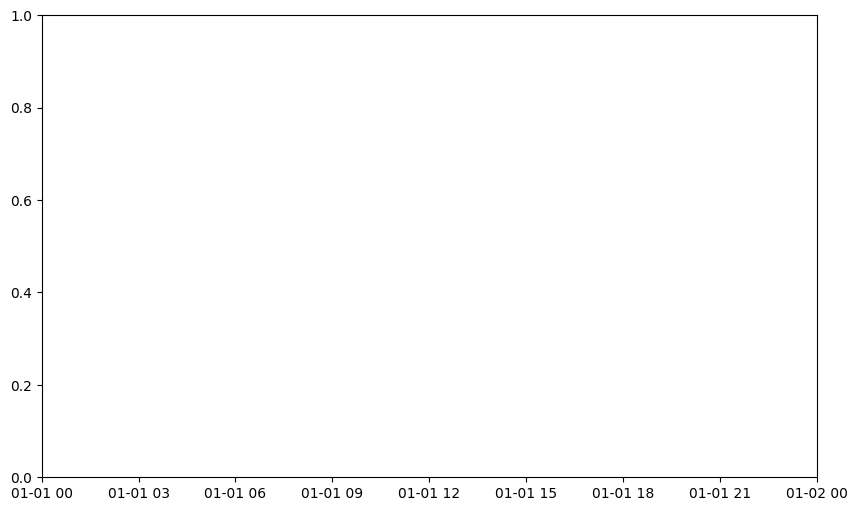

In [18]:
import matplotlib.pyplot as plt

# Plot the data and the trend line
plt.figure(figsize=(10, 6))
plt.scatter(df['Date'].to_list(), y, color='blue', label='PM2.5 measurements')
plt.plot(df['Date'].to_list(), y_pred, color='red', label='Trend line')

# Labels and title
plt.title('PM2.5 Trend at Station DL002', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('PM2.5 Concentration (µg/m³)', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from scipy import stats

# Perform the statistical test
slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)

# Print the results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")


In [29]:
# import polars as pl
# from datetime import datetime

# # Sample DataFrame with a 'date' column
# df = pl.DataFrame({
#     "date": [
#         "2023-10-01", 
#         "2023-10-05", 
#         "2023-10-10"
#     ]
# }).with_columns(pl.col("date").str.strptime(pl.Date, format="%Y-%m-%d"))

# # Get the first date in the column
# first_date = df.select(pl.col("date").min()).item()

# # Calculate the number of days passed since the first date
# df_with_days_passed = df.with_columns(
#     (pl.col("date") - first_date).dt.total_days().alias("days_passed")
# )

# # Display the result
# print(df_with_days_passed)

shape: (3, 2)
┌────────────┬─────────────┐
│ date       ┆ days_passed │
│ ---        ┆ ---         │
│ date       ┆ i64         │
╞════════════╪═════════════╡
│ 2023-10-01 ┆ 0           │
│ 2023-10-05 ┆ 4           │
│ 2023-10-10 ┆ 9           │
└────────────┴─────────────┘
